<a href="https://colab.research.google.com/github/phuongtranth/RFM-Analysis/blob/main/RFM_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data and library

In [3]:
!pip install squarify
import squarify
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

transactions = pd.read_excel('/content/drive/MyDrive/PJ3 Python/ecommerce retail.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cleaning data



In [4]:
transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#Check for missing data in each column
transactions.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Next step: remove rows had null CustomerID

In [7]:
transactions = transactions.dropna(subset=['CustomerID'])

In [8]:
#Check for duplicates
print(transactions.duplicated().sum(), " duplicate(s)")

5225  duplicate(s)


Next step: remove all duplicates

In [9]:
transactions = transactions.drop_duplicates()

In [10]:
#Check for datatype
transactions.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


- CustomerID should be object

In [11]:
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'])
transactions['CustomerID'] = transactions['CustomerID'].astype('object')

- '.0' in CustomerID should be remove

In [12]:
transactions['CustomerID'] = transactions['CustomerID'].astype(str).str.replace('.0', '', regex=False)
transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [13]:
#Check for incorrect values
transactions.describe()

,Quantity,InvoiceDate,UnitPrice
count,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:30,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283037,NaN,69.764035


Quantity and Unitprice had negative values

Next step:
Filter data that >0 in Quantity and Unitprice and not cancelled transactions (InvoiceNo not star with C)



In [14]:
transactions = transactions[
    (~transactions['InvoiceNo'].astype(str).str.startswith('C')) &
    (transactions['Quantity'] > 0) &
    (transactions['UnitPrice'] > 0)
]
transactions.describe()

,Quantity,InvoiceDate,UnitPrice
count,392692.000000,392692,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.492832,NaN,22.241836


# Calculating RFM

In [15]:
# Calculate Recency
last_purchase_date = transactions.groupby('CustomerID')['InvoiceDate'].max().reset_index(name='LastPurchaseDate')
today = pd.to_datetime('2011-12-31')
last_purchase_date['Recency'] = (today - last_purchase_date['LastPurchaseDate']).dt.days

# Calculate Frequency
frequency = transactions.groupby('CustomerID')['InvoiceDate'].nunique().reset_index(name='Frequency')
frequency['Rank'] = frequency['Frequency'].rank(method='first').astype(int)

# Calculate Monetary
monetary = transactions.assign(Revenue=transactions['Quantity'] * transactions['UnitPrice']).groupby('CustomerID')['Revenue'].sum().reset_index(name='Monetary')

# Merge in 1 df
rfm = last_purchase_date.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.shape

(4338, 6)

In [16]:
# Quintile
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Rank'], q=5, labels= [1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels= [1,2,3,4,5])

# Create RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Rank,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,2011-01-18 10:01:00,346,1,1,77183.60,1,1,5,115
1,12347,2011-12-07 15:52:00,23,7,3642,4310.00,5,5,5,555
2,12348,2011-09-25 13:13:00,96,4,2837,1797.24,2,4,4,244
3,12349,2011-11-21 09:51:00,39,1,2,1757.55,4,1,4,414
4,12350,2011-02-02 16:01:00,331,1,3,334.40,1,1,2,112


# Segmentation

In [17]:
def segment_customers(row):
    score = row['RFM_Score']
    if score in ['555', '554', '544', '545', '454', '455', '445']:
        return 'Champions'
    elif score in ['543', '444', '435', '355', '354', '345', '344', '335']:
        return 'Loyal'
    elif score in ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']:
        return 'Potential Loyalist'
    elif score in ['512', '511', '422', '421', '412', '411', '311']:
        return 'New Customers'
    elif score in ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']:
        return 'Promising'
    elif score in ['535', '534', '443', '434', '343', '334', '325', '324']:
        return 'Need Attention'
    elif score in ['331', '321', '312', '221', '213', '231', '241', '251']:
        return 'About To Sleep'
    elif score in ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']:
        return 'At Risk'
    elif score in ['155', '154', '144', '214', '215', '115', '114', '113']:
        return 'Cannot Lose Them'
    elif score in ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211']:
        return 'Hibernating customers'
    elif score in ['111', '112', '121', '131', '141', '151']:
        return 'Lost customers'
    else:
        return 'Unknown'

# Apply the segmentation function to create a new 'Segment' column
rfm['Segment'] = rfm.apply(segment_customers, axis=1)

rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Rank,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,2011-01-18 10:01:00,346,1,1,77183.60,1,1,5,115,Cannot Lose Them
1,12347,2011-12-07 15:52:00,23,7,3642,4310.00,5,5,5,555,Champions
2,12348,2011-09-25 13:13:00,96,4,2837,1797.24,2,4,4,244,At Risk
3,12349,2011-11-21 09:51:00,39,1,2,1757.55,4,1,4,414,Promising
4,12350,2011-02-02 16:01:00,331,1,3,334.40,1,1,2,112,Lost customers


# Visualization

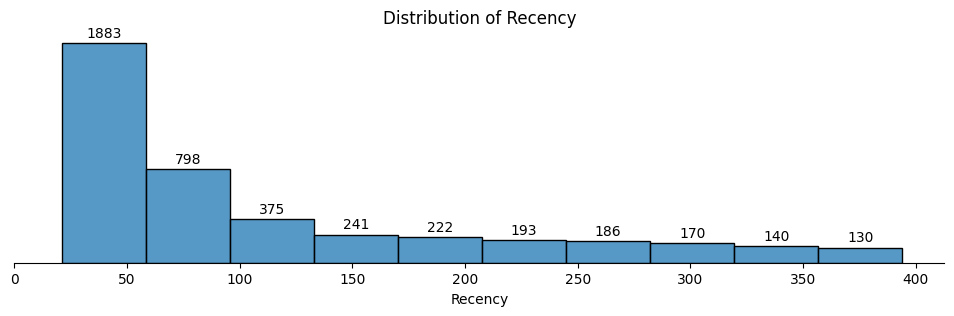

In [18]:
#Distribution of Recency
fig, ax = plt.subplots(figsize=(12, 3))
sns.histplot(data=rfm, x='Recency', bins =10, ax=ax)
ax.set_title('Distribution of Recency')
ax.set_xlim(left=0)
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

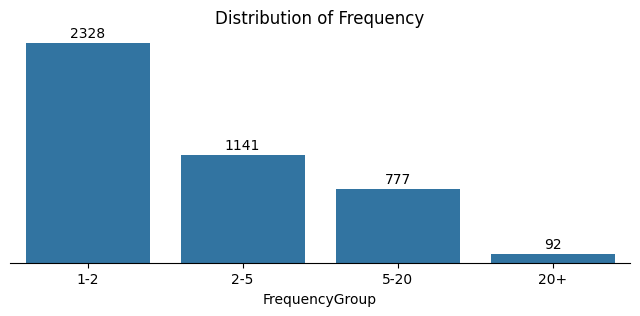

In [19]:
#Distribution of Frequency
binsF = [0, 2, 5, 20, np.inf]
labelsF = ['1-2', '2-5', '5-20', '20+']
rfm['FrequencyGroup'] = pd.cut(rfm['Frequency'], bins=binsF, labels=labelsF)
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='FrequencyGroup', data=rfm, ax=ax)
ax.set_title('Distribution of Frequency')
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()


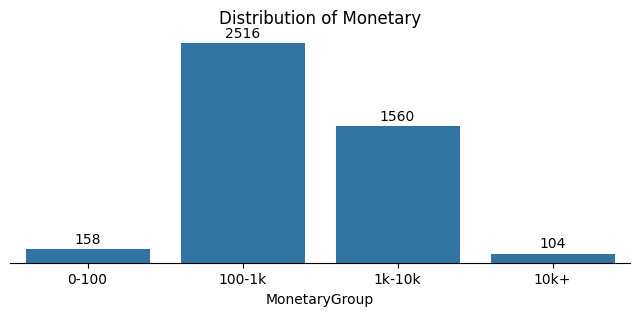

In [20]:
#Distribution of Monetary
binsM = [0, 100, 1000, 10000, np.inf]
labelsM = ['0-100', '100-1k', '1k-10k', '10k+']
rfm['MonetaryGroup'] = pd.cut(rfm['Monetary'], bins=binsM, labels=labelsM)
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='MonetaryGroup', data=rfm, ax=ax)
ax.set_title('Distribution of Monetary')
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

In [21]:
segment_colors = {
    'Champions': '#FF0000',
    'Loyal': '#00FFFF',
    'Potential Loyalist': '#00FF00',
    'At Risk': '#FFFF00',
    'Hibernating customers': '#800080',
    'Lost customers': '#FFA500',
    'Need Attention': '#A52A2A',
    'About To Sleep': '#808000',
    'New Customers': '#FFC0CB',
    'Promising': '#FF00FF',
    'Cannot Lose Them': '#736F6E'
}

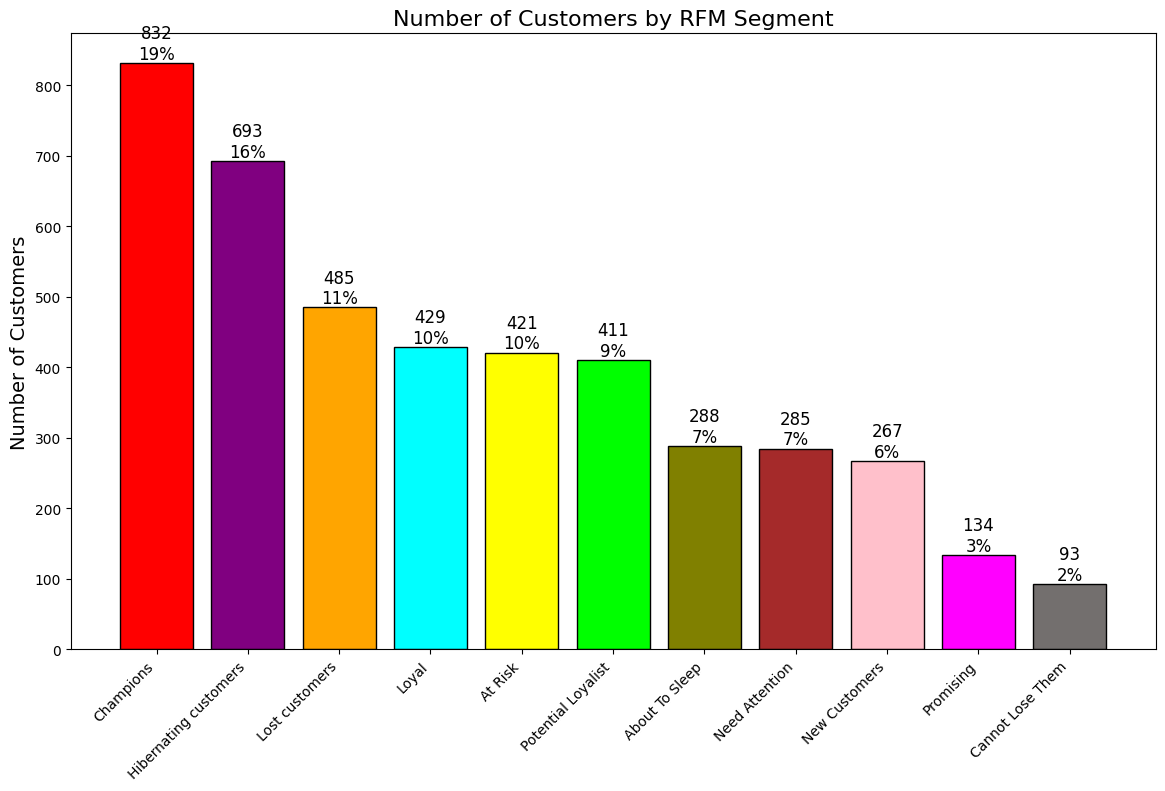

In [27]:
# Sort data by the number of customers in descending order
Number_of_customer = Number_of_customer.sort_values('Cust_count', ascending=False)

# Sort data by the number of customers in descending order
Number_of_customer = Number_of_customer.sort_values('Cust_count', ascending=False)

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot
bars = ax.bar(Number_of_customer['Segment'],
              Number_of_customer['Cust_count'],
              color=[segment_colors[segment] for segment in Number_of_customer['Segment']],
              edgecolor="black")

# Adding labels on top of bars
for bar, count, share in zip(bars, Number_of_customer['Cust_count'], Number_of_customer['Count_share']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f"{count:,}\n{int(round(share))}%",
            ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title('Number of Customers by RFM Segment', fontsize=16)
plt.ylabel('Number of Customers', fontsize=14)

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.show()

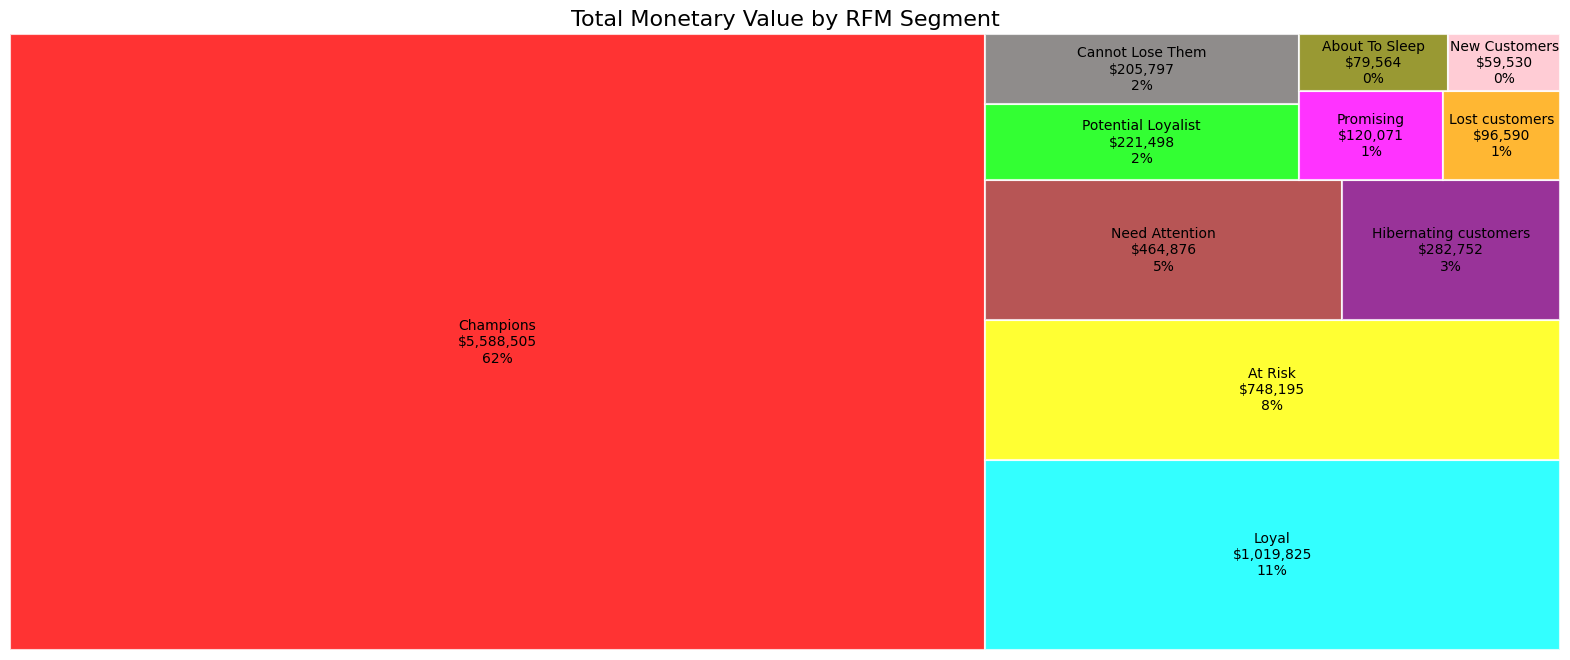

In [23]:

# % and Monetary values by Segment
segment_monetary = rfm.groupby('Segment')['Monetary'].sum().reset_index()
total_monetary = segment_monetary['Monetary'].sum()
segment_monetary['Percentage'] = segment_monetary['Monetary'] / total_monetary * 100

segment_monetary = segment_monetary.sort_values('Monetary', ascending=False)

# Create the treemap

fig, ax = plt.subplots(1, figsize=(20,8))
squarify.plot(sizes=segment_monetary['Monetary'],
              label=[f"{s}\n${int(m):,}\n{int(p)}%"
                     for s, m, p in zip(segment_monetary['Segment'],
                                        segment_monetary['Monetary'],
                                        segment_monetary['Percentage'])],
              color=[segment_colors[segment] for segment in segment_monetary['Segment']],
              alpha=0.8,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('Total Monetary Value by RFM Segment', fontsize=16)
plt.axis('off')

plt.show()